In [2]:
import seaborn as sns

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("G:\\Assignment\\DT-BrainCancer.csv")
df.head(10)

,Unnamed: 0,sex,diagnosis,loc,ki,gtv,status
0,1,Female,Meningioma,Infratentorial,90,6.11,0
1,2,Male,HG glioma,Supratentorial,90,19.35,1
2,3,Female,Meningioma,Infratentorial,70,7.95,0
3,4,Female,LG glioma,Supratentorial,80,7.61,1
4,5,Male,HG glioma,Supratentorial,90,5.06,1
5,6,Female,Meningioma,Supratentorial,80,4.82,0
6,7,Male,Meningioma,Supratentorial,80,3.19,0
7,8,Male,LG glioma,Supratentorial,80,12.37,0
8,9,Female,Meningioma,Supratentorial,70,12.16,0
9,10,Male,HG glioma,Supratentorial,100,2.53,0


In [3]:
df.shape

(88, 7)

In [4]:
df.describe()

,Unnamed: 0,ki,gtv,status
count,88.000000,88.000000,88.000000,88.000000
mean,44.500000,81.022727,8.660795,0.397727
std,25.547342,10.508866,8.657576,0.492233
min,1.000000,40.000000,0.010000,0.000000
25%,22.750000,80.000000,2.500000,0.000000
50%,44.500000,80.000000,6.510000,0.000000
75%,66.250000,90.000000,12.100000,1.000000
max,88.000000,100.000000,34.640000,1.000000


In [5]:
df.isnull().sum()

Unnamed: 0    0
sex           0
diagnosis     1
loc           0
ki            0
gtv           0
status        0
dtype: int64

In [6]:
df.dropna(subset=['diagnosis'], inplace=True)

In [7]:
df.isnull().sum()

Unnamed: 0    0
sex           0
diagnosis     0
loc           0
ki            0
gtv           0
status        0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 87
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  87 non-null     int64  
 1   sex         87 non-null     object 
 2   diagnosis   87 non-null     object 
 3   loc         87 non-null     object 
 4   ki          87 non-null     int64  
 5   gtv         87 non-null     float64
 6   status      87 non-null     int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.4+ KB


In [9]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
X, y = df.drop("status", axis=1), df[['status']]

# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(y)

# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to pd.Categorical
for col in cats:
   X[col] = X[col].astype('category')

In [10]:
X.dtypes

Unnamed: 0       int64
sex           category
diagnosis     category
loc           category
ki               int64
gtv            float64
dtype: object

In [34]:
# Split the data into 70% train, 15% validation, and 15% test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [35]:
X_train.shape, X_val.shape, X_test.shape

((60, 6), (13, 6), (14, 6))

In [36]:
import xgboost as xgb

# Create regression matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
dval_clf = xgb.DMatrix(X_val, y_valid, enable_categorical=True)

In [37]:
# Define hyperparameters to tune
hyperparameters_to_tune = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.001, 0.01, 0.1, 0.3],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2, 0,3],
}

# Use Grid Search or Random Search to find optimal hyperparameters
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method="gpu_hist", enable_categorical = True)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=hyperparameters_to_tune, cv=5, scoring="accuracy")
grid_search.fit(X_val, y_valid)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 3}


In [38]:
# Train the model with the best parameters
best_model = xgb.XGBClassifier(objective="binary:logistic", tree_method="gpu_hist", **best_params, enable_categorical = True)
best_model.fit(X_train, y_train)

# Predict on test set
y_pred = best_model.predict(X_test)

y_pred



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
accuracy = np.mean(y_pred == y_test.values)
print("Accuracy:", accuracy)


Accuracy: 0.8571428571428571


In [49]:
y_test_values_reshaped = y_test.values.flatten()


In [50]:
confusion_matrix = np.zeros((len(np.unique(y_test.values)), len(np.unique(y_test.values))))
for i in range(len(y_test)):
    confusion_matrix[y_test.values[i], y_pred[i]] += 1
print("Confusion Matrix:")
print(confusion_matrix)

precision = np.zeros(len(np.unique(y_test_values_reshaped)))
recall = np.zeros(len(np.unique(y_test_values_reshaped)))
f_score = np.zeros(len(np.unique(y_test_values_reshaped)))
for i in range(len(np.unique(y_test_values_reshaped))):
    true_positive = confusion_matrix[i, i]
    false_positive = np.sum(confusion_matrix[:, i]) - true_positive
    false_negative = np.sum(confusion_matrix[i, :]) - true_positive
    precision[i] = true_positive / (true_positive + false_positive)
    recall[i] = true_positive / (true_positive + false_negative)
    f_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", f_score)

precision_recall_curve = []
for threshold in np.linspace(0, 1, 100):
    y_pred_thresh = y_pred >= threshold
    true_positive = np.sum(y_pred_thresh[y_test_values_reshaped == 1])
    false_positive = np.sum(y_pred_thresh[y_test_values_reshaped == 0])
    false_negative = np.sum(~y_pred_thresh[y_test_values_reshaped == 1])
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    precision_recall_curve.append((precision, recall))
print("Precision-Recall Curve Points:", precision_recall_curve)




Confusion Matrix:
[[12.  0.]
 [ 2.  0.]]
Precision: [0.85714286        nan]
Recall: [1. 0.]
F-score: [0.92307692        nan]
Precision-Recall Curve Points: [(0.14285714285714285, 1.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0),

In [48]:
print("Shape of y_pred_thresh:", y_pred_thresh.shape)
print("Shape of y_test.values:", y_test.values.shape)


Shape of y_pred_thresh: (14,)
Shape of y_test.values: (14, 1)


In [51]:
# Precision, Recall, F-score
precision = np.zeros(len(np.unique(y_test)))
recall = np.zeros(len(np.unique(y_test)))
f_score = np.zeros(len(np.unique(y_test)))
for i in range(len(np.unique(y_test))):
    true_positive = confusion_matrix[i, i]
    false_positive = np.sum(confusion_matrix[:, i]) - true_positive
    false_negative = np.sum(confusion_matrix[i, :]) - true_positive
    if true_positive + false_positive == 0:
        precision[i] = 0
    else:
        precision[i] = true_positive / (true_positive + false_positive)
    if true_positive + false_negative == 0:
        recall[i] = 0
    else:
        recall[i] = true_positive / (true_positive + false_negative)
    if precision[i] + recall[i] == 0:
        f_score[i] = 0
    else:
        f_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

print("Precision:", precision)
print("Recall:", recall)
print("F-score:", f_score)

# Precision-Recall Curve Points
precision_recall_curve = []
for threshold in np.linspace(0, 1, 100):
    y_pred_thresh = y_pred >= threshold
    true_positive = np.sum(y_pred_thresh[y_test.values.flatten() == 1])
    if np.sum(y_test.values.flatten() == 1) == 0:
        precision = 0
    else:
        precision = true_positive / np.sum(y_pred_thresh)
    recall = true_positive / np.sum(y_test.values.flatten() == 1)
    precision_recall_curve.append((precision, recall))

print("Precision-Recall Curve Points:", precision_recall_curve)


Precision: [0.85714286 0.        ]
Recall: [1. 0.]
F-score: [0.92307692 0.        ]
Precision-Recall Curve Points: [(0.14285714285714285, 1.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan, 0.0), (nan

Precision: [0.85714286 0.        ]
Recall: [1. 0.]
F-score: [0.92307692 0.        ]
Precision-Recall Curve Points: [(0.14285714285714285, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.

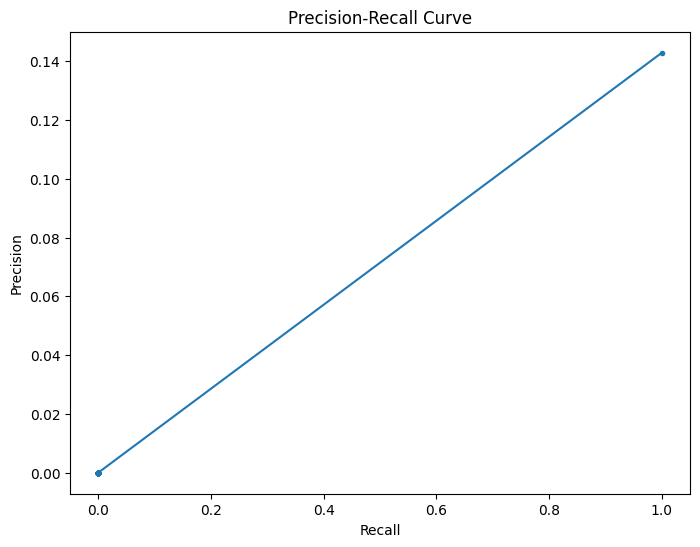

In [92]:
# Precision, Recall, F-score
precision = np.zeros(len(np.unique(y_test)))
recall = np.zeros(len(np.unique(y_test)))
f_score = np.zeros(len(np.unique(y_test)))
for i in range(len(np.unique(y_test))):
    true_positive = confusion_matrix[i, i]
    false_positive = np.sum(confusion_matrix[:, i]) - true_positive
    false_negative = np.sum(confusion_matrix[i, :]) - true_positive
    
    if true_positive + false_positive == 0:
        precision[i] = 0
    else:
        precision[i] = true_positive / (true_positive + false_positive)
        
    if true_positive + false_negative == 0:
        recall[i] = 0
    else:
        recall[i] = true_positive / (true_positive + false_negative)
        
    if precision[i] + recall[i] == 0:
        f_score[i] = 0
    else:
        f_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

print("Precision:", precision)
print("Recall:", recall)
print("F-score:", f_score)

# Precision-Recall Curve Points
precision_recall_curve = []
for threshold in np.linspace(0, 1, 100):
    y_pred_thresh = y_pred >= threshold
    true_positive = np.sum(y_pred_thresh[y_test.values.flatten() == 1])
    if np.sum(y_pred_thresh) == 0:
        precision = 0
    else:
        precision = true_positive / np.sum(y_pred_thresh)
        
    recall = true_positive / np.sum(y_test.values.flatten() == 1)
    precision_recall_curve.append((precision, recall))

print("Precision-Recall Curve Points:", precision_recall_curve)


import numpy as np
import matplotlib.pyplot as plt

precision_recall_curve = []
for threshold in np.linspace(0, 1, 100):
    y_pred_thresh = y_pred >= threshold
    true_positive = np.sum(y_pred_thresh[y_test.values.flatten() == 1])
    false_positive = np.sum(y_pred_thresh[y_test.values.flatten() == 0])
    false_negative = np.sum(~y_pred_thresh[y_test.values.flatten() == 1])
    
    if true_positive + false_positive == 0:
        precision = 0
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if true_positive + false_negative == 0:
        recall = 0
    else:
        recall = true_positive / (true_positive + false_negative)
        
    precision_recall_curve.append((precision, recall))

# Unpack precision and recall values
precisions, recalls = zip(*precision_recall_curve)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()






In [91]:
precisions

(0.14285714285714285,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0)

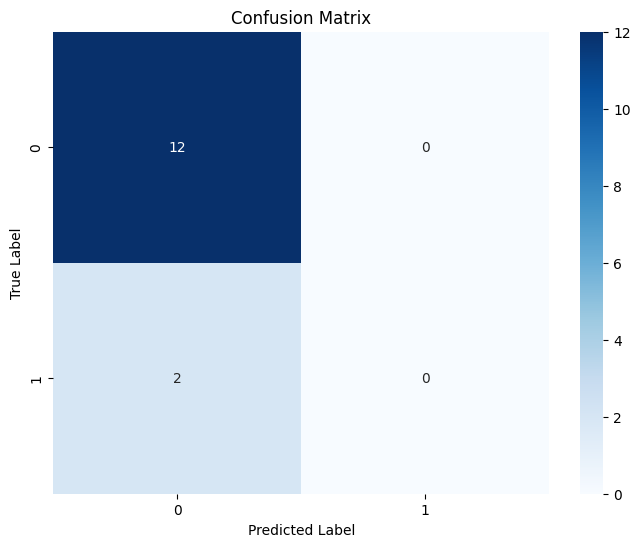

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt=".0f")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


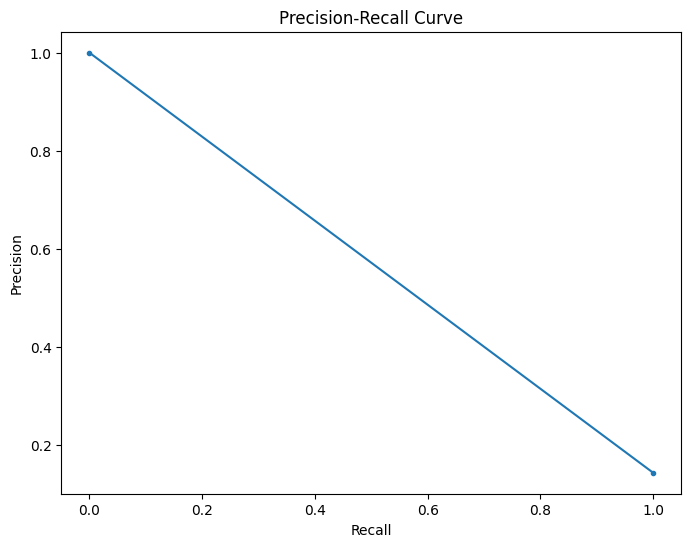

Area Under Precision-Recall Curve: 0.5714285714285714


In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Plot Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Compute Area Under Curve (AUC) for Precision-Recall Curve
pr_auc = auc(recall, precision)
print(f"Area Under Precision-Recall Curve: {pr_auc}")

In [76]:
print("Precision-Recall Curve Points:")
for p, r in zip(precision, recall):
    print(f"Precision: {p}, Recall: {r}")

Precision-Recall Curve Points:
Precision: 0.14285714285714285, Recall: 1.0
Precision: 1.0, Recall: 0.0


In [100]:
(precision[:1])

array([0.14285714])

In [71]:
recall

array([1., 0.])

In [105]:
y_test.values

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)